In [1]:
!pip install pennylane --upgrade

In [2]:
# QML imports
import pennylane as qml

# MNIST Dataset
from tensorflow.keras.datasets import mnist

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow import Variable

import numpy as np
import matplotlib.pyplot as plt

# Dataset preparation and info

In [3]:
# Load MNIST dataset using TensorFlow
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


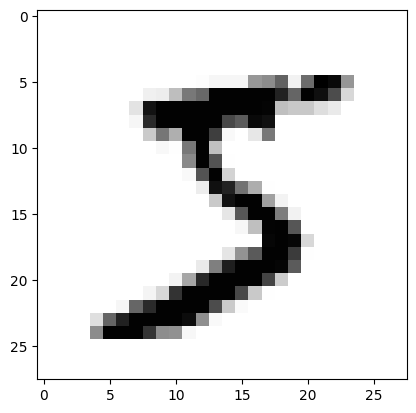

In [4]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

# extract one image data
plt.imshow(train_images[0, :, :], cmap='Greys')

In [5]:
# flat_img = train_images[0, :, :].flatten()
print('max:', np.max(train_images[0, :, :]), 'min:', np.min(train_images[0, :, :]))

max: 255 min: 0


As we would see in the encoding section, the best we can do to store classical information in qubits limits to $2^{n}$ classical features into n qubits

To store 784 pixel data into amplitude, we need atleast a 10 qubit state to store the image data. This when put into a circuit to compare 2 images, the qubit requirements may go to 25-30 qubits. Simulating this circuit will go beyond the compute limits.  
  
  
So we reduce the image size to 16x16 = 256 pixel values. This can be put into a 8 qubit state, reducing the qubit sizes as much as possible.

We normalize the data arrays from ranges [0, 255] to [0, 1], And resize the images to 16x16

(60000, 28, 28, 1)
(60000, 16, 16, 1)


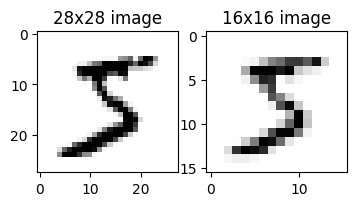

In [6]:
train_images = train_images.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0  # Reshape into 4d array and normalize
print(train_images.shape)

# resize the images to 16x16
X_train = tf.image.resize(train_images, [16,16])
print(X_train.shape)

plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.imshow(train_images[0, :, :], cmap='Greys')
plt.title('28x28 image')

plt.subplot(1, 2, 2)
plt.imshow(X_train[0, :, :], cmap='Greys')
plt.title('16x16 image')

plt.show()

# Quantum Circuits and Encoding

We see that images are of size 16x16 ie., 256 pixels with each pixel having a float value. So to store their info, we require a state where we can encode atleast 256 values as amplitudes/phases.  

Available encoding methods are:  
1. Amplitude encoding - $2^{n}$ features into n qubits
2. Phase angle encoding - Encodes Max of n features into n qubits
3. Basis Encoding - Encodes n binary features into a basis state of n qubits.  

There are other encodings which are more complicated, but dont provide the high num_features to qubit ratio that amplitude encoding provides, So we go forward with amplitude encoding.

In [7]:
num_qubits = 8

@qml.qnode(qml.device('default.qubit'), wires=8)
def imageToState(image_array, weights):
    # image_array is (16, 16) shaped 2d numpy array
    # weights are (256,) shaped numpy 1d array
    flattened = tf.reshape(image_array, [-1])
    features = flattened * weights
    qml.AmplitudeEmbedding(features=features, wires=range(num_qubits), normalize=True)

    return qml.state()

/usr/local/lib/python3.10/dist-packages/pennylane/workflow/qnode.py:475: UserWarning: Received gradient_kwarg wires, which is not included in the list of standard qnode gradient kwargs.
  warnings.warn(


In [8]:
num_qubits = 8

@qml.qnode(qml.device('default.qubit'))
def swapTestCircuit(state1, state2):
    # state1, state2 are 8 qubit states initialized from image arrays
    # function returns the measurement from the topmost qubit (wire0) where the swap test results are stored

    # initialize states
    qml.QubitStateVector(state1, wires=range(1, 9))
    qml.QubitStateVector(state2, wires=range(9, 17))

    qml.Barrier(wires=range(16))

    # swap test
    qml.Hadamard(0)
    for i in range(1, 9):
        qml.CSWAP(wires = [0, i, 8+i])
    qml.Hadamard(0)

    return qml.probs(wires=0)

def getFidelity(state1, state2):
    probs = swapTestCircuit(state1, state2)
    return probs[0]

(<Figure size 1500x1800 with 1 Axes>, <Axes: >)

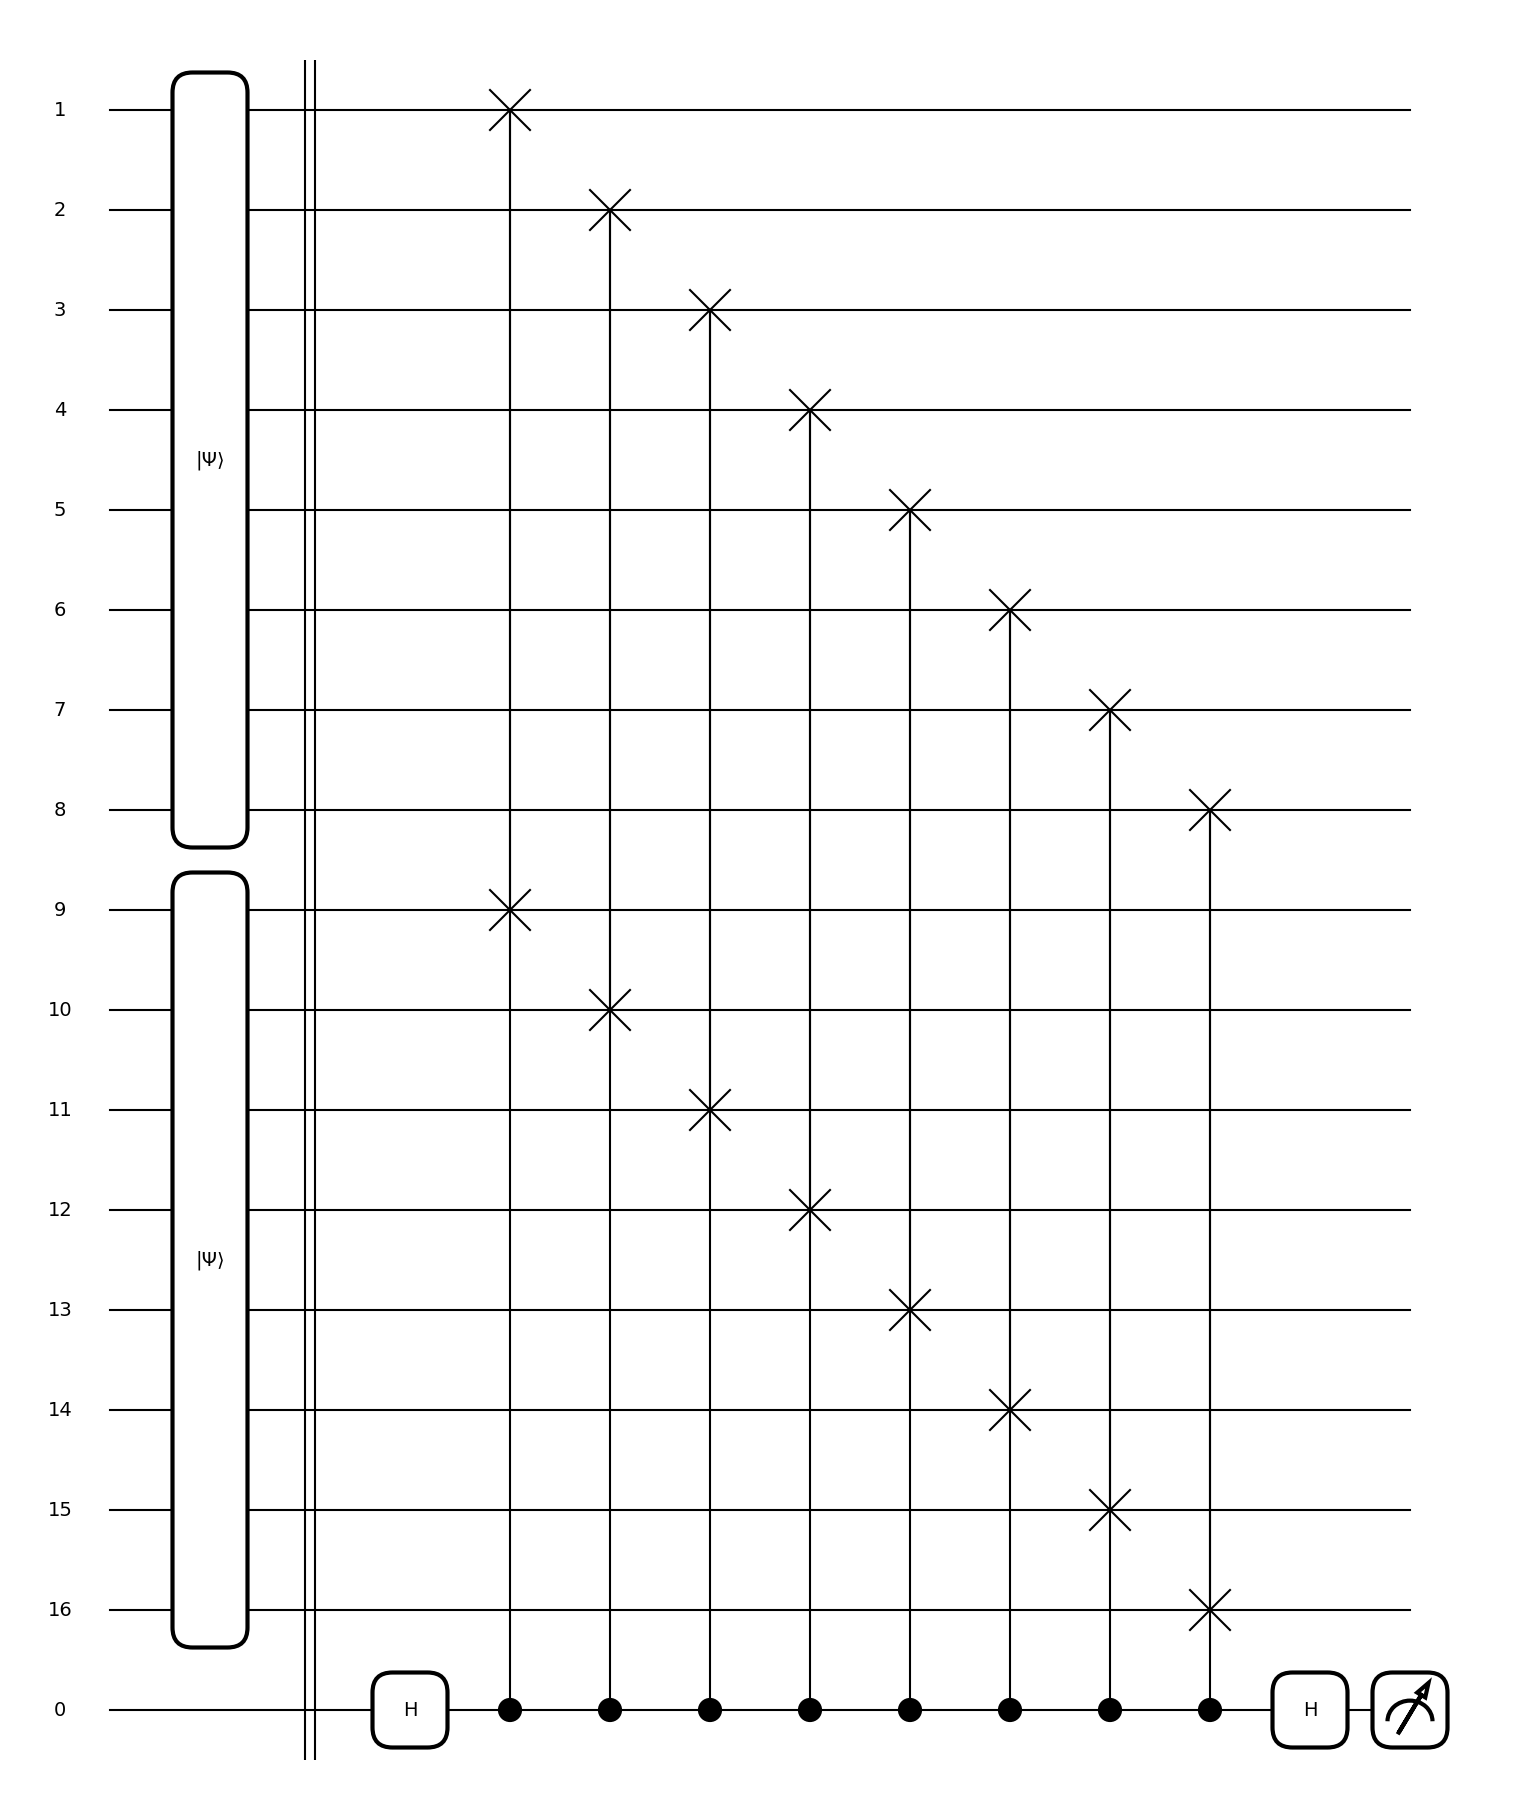

In [9]:
sv = imageToState(X_train[0, :, :, 0], np.random.rand(256))
qml.draw_mpl(swapTestCircuit)(sv, sv)

In [10]:
# define the final model and loss function
# both individual functions are combined into a single circuit, to speed up execution

@qml.qnode(qml.device('default.qubit'))
def quantumRepModel(inputs, weights0):
    image1, image2 = inputs
    # Embed images into quantum states
    im_arr1 = image1[:, :, 0]
    im_arr2 = image2[:, :, 0]
    #state1 = imageToState(im_arr1, weights)

    flattened1 = tf.reshape(im_arr1, [-1])
    features1 = flattened1 * weights0
    qml.AmplitudeEmbedding(features=features1, wires=range(1, 9), normalize=True)

    #state2 = imageToState(im_arr2, weights)
    flattened2 = np.array(im_arr2).flatten()
    features2 = flattened2 * weights0
    qml.AmplitudeEmbedding(features=features2, wires=range(9, 17), normalize=True)

    # Calculate fidelity between quantum states
    # fidelity = swapTestCircuit(state1, state2)[0]
    qml.Barrier(wires=range(16))

    # swap test
    qml.Hadamard(0)
    for i in range(1, 9):
        qml.CSWAP(wires = [0, i, 8+i])
    qml.Hadamard(0)

    return qml.probs(wires=0)

    # # Define contrastive loss based on image labels
    # loss = tf.cond(tf.equal(label1, label2),
    #                lambda: 1 - fidelity,
    #                lambda: tf.maximum(0., fidelity))

    # return loss

In [11]:
k = quantumRepModel((X_train[0], X_train[0]), np.random.rand(256))

In [12]:
np.shape(k)

(2,)

In [14]:
# Define the quantum circuit model
class QuantumModel(tf.keras.Model):
    def __init__(self):
        super(QuantumModel, self).__init__()
        self.num_parameters = 256
        self.params = tf.Variable(tf.random.normal(shape=(self.num_parameters,)), trainable=True)

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        img1, y1, img2, y2 = data

        with tf.GradientTape() as tape:
            fidelity = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compute_loss(y=fidelity, y_pred=(y1, y2))

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    def call(self, inputs):
        image1, image2, label1, label2 = inputs
        # Embed images into quantum states
        im_arr1 = image1[:, :, 0]
        im_arr2 = image2[:, :, 0]
        state1 = imageToState(im_arr1, self.params)

        state2 = imageToState(im_arr2, self.params)

        # Calculate fidelity between quantum states
        qml.Barrier(wires=range(16))

        fidelity = getFidelity(state1, state2)

        return fidelity

    def compute_loss(y, y_pred):
        fidelity = y
        label1, label2 = y_pred

        # Define contrastive loss based on image labels
        loss = tf.cond(tf.equal(label1, label2),
                        lambda: 1 - fidelity,
                        lambda: tf.maximum(0., fidelity))

        return loss

In [15]:
# Initialize the quantum model
quantum_model = QuantumModel()

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [39]:
# Define training step
batch_size = 32

@tf.function
def train_step(image1, image2, label1, label2):

    with tf.GradientTape() as tape:
        # Forward pass: compute contrastive loss
        loss = quantum_model.compute_loss(quantum_model((image1, image2, label1, label2)), label1, label2)

    # Compute gradients
    gradients = tape.gradient(loss, quantum_model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, quantum_model.trainable_variables))

    return loss

# Training loop
num_epochs = 10
for epoch in range(num_epochs):

        image_batch, label_batch = next(image.ImageDataGenerator().flow(X_train, train_labels, batch_size=batch_size))
        # Sample another batch for contrastive loss (ideally with different labels)
        image_batch2, label_batch2 = next(image.ImageDataGenerator().flow(X_train, train_labels, batch_size=batch_size, shuffle=True))

        # Perform training step
        loss = train_step(image_batch[0], image_batch2[0], label_batch[0], label_batch2[0])

        print(f"Epoch {epoch + 1}, Step {i + 1}, Loss: {loss.numpy()}")

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


TypeError: in user code:

    File "<ipython-input-39-a06f547d5c60>", line 9, in train_step  *
        loss = quantum_model.compute_loss(quantum_model((image1, image2, label1, label2)), label1, label2)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileuaa25116.py", line 17, in tf__call
        loss = ag__.converted_call(ag__.ld(tf).cond, (ag__.converted_call(ag__.ld(tf).equal, (ag__.ld(label1), ag__.ld(label2)), None, fscope), ag__.autograph_artifact(lambda : 1 - ag__.ld(fidelity)), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(tf).maximum, (0.0, ag__.ld(fidelity)), None, fscope))), None, fscope)
    File "/tmp/__autograph_generated_fileuaa25116.py", line 17, in <lambda>
        loss = ag__.converted_call(ag__.ld(tf).cond, (ag__.converted_call(ag__.ld(tf).equal, (ag__.ld(label1), ag__.ld(label2)), None, fscope), ag__.autograph_artifact(lambda : 1 - ag__.ld(fidelity)), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(tf).maximum, (0.0, ag__.ld(fidelity)), None, fscope))), None, fscope)

    TypeError: Exception encountered when calling layer 'quantum_model' (type QuantumModel).
    
    in user code:
    
        File "<ipython-input-14-de3c3b0adfe7>", line 30, in call  *
            loss = tf.cond(tf.equal(label1, label2),
    
        TypeError: Input 'y' of 'Maximum' Op has type float64 that does not match type float32 of argument 'x'.
    
    
    Call arguments received by layer 'quantum_model' (type QuantumModel):
      • inputs=('tf.Tensor(shape=(16, 16, 1), dtype=float32)', 'tf.Tensor(shape=(16, 16, 1), dtype=float32)', 'tf.Tensor(shape=(), dtype=uint8)', 'tf.Tensor(shape=(), dtype=uint8)')


In [ ]:
# save weights after the training process
quantum_model.save_weights("mnist_quantum_rep_weights.h5")